### Light GBM Regression Model for Surface Roughness Prediction

In [217]:
import pandas as pd
import numpy as np
import heapq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

### Down Milling

#### Feature Set 1

##### Using all Features without Hyperparametertuning

In [2]:
up_or_down = 'down' # or down
all_data = pd.read_csv('../data/feature_set1/train_{}_Y.csv'.format(up_or_down))
all_data = all_data.drop(index = [48, 49, 51, 72, 91], axis=0).reset_index(drop=True)  # remove outliers
all_data.head()

Nr.  spindle_speed   ap     fz   Ra_down   vbs   clamp_t1     clamp_t2  \
0    1           8000  0.2  0.050  12.83250   800  23.664093   917.580527   
1    2           8000  0.2  0.065   6.47625  1040  28.025455  1817.287671   
2    3           8000  0.2  0.075   8.42100  1200  24.258964  2600.600669   
3    4           8000  0.2  0.100   6.81600  1600  23.584906  4141.970983   
4    5           8000  0.4  0.050  12.51250   800  43.182927  1232.354156   

    clamp_t3  clamp_t4  ...  robot_t4  robot_t5  robot_t6  robot_t7  robot_t8  \
0  38.393060     131.0  ...    1159.0     340.0 -0.164626  3.279446  1.164723   
1  50.951992     153.0  ...    1114.0     286.0 -0.152276  2.869851  1.125636   
2  56.380290     175.0  ...    1205.0     350.0  0.195294  2.681590  1.214723   
3  68.429443     212.0  ...    1206.0     438.0 -0.022681  2.818957  1.221912   
4  55.606742     132.0  ...    1147.0     275.0  0.136498  2.464138  1.154345   

   robot_t9   clamp_f1   clamp_f2   robot_f1   robot_f2  
0  1.162811  12.222404  19.191919  22.863227  14.646465  
1  1.123908  17.382572  21.717172  25.495338  31.313131  
2  1.212308  20.770490  21.717172  37.602301  31.313131  
3  1.217963  27.491432  21.717172  39.944840   5.050505  
4  1.152213  18.159337   9.595960  33.502295   6.060606  

[5 rows x 28 columns]

In [3]:
used_feature = ['spindle_speed', 'ap', 'fz','vbs', 'clamp_t1',
       'clamp_t2', 'clamp_t3', 'clamp_t4', 'clamp_t5', 'clamp_t6', 'clamp_t7', 'clamp_t8', 'clamp_t9',
       'clamp_f1', 'clamp_f2',
       'robot_t1', 'robot_t2', 'robot_t3', 'robot_t4', 'robot_t5', 'robot_t6', 'robot_t7', 'robot_t8', 'robot_t9',
       'robot_f1', 'robot_f2']

**Train-test-split**

In [4]:
X = all_data[used_feature]
Y = all_data['Ra_{}'.format(up_or_down)]

x_train, x_test , y_train, y_test= train_test_split(X, Y,test_size = 0.2, random_state=20, shuffle=True)

**Train the LGBM Regression Model**

In [5]:
lgbm = LGBMRegressor(random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [6]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [7]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 2.46
Coefficient of determination: 0.70
MAE:0.91
mean_absolute_percentage_error:0.12


##### Using all Features with Hyperparametertuning

**Train the LGBM Regression Model**

In [8]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [9]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [10]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [11]:
lgbm_random.best_params_

{'num_leaves': 11, 'min_data_in_leaf': 2, 'max_depth': 140}

In [12]:
lgbm = LGBMRegressor(num_leaves=11, min_data_in_leaf=2, max_depth=140, random_state=20)

lgbm.fit(x_train, y_train,)

LGBMRegressor(max_depth=140, min_data_in_leaf=2, num_leaves=11, random_state=20)

In [13]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [14]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.00
Coefficient of determination: 1.00
MAE:0.01
mean_absolute_percentage_error:0.00


**Test Metrics**

In [15]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 0.60
Coefficient of determination: 0.93
MAE:0.55
mean_absolute_percentage_error:0.08


**Fit Result**

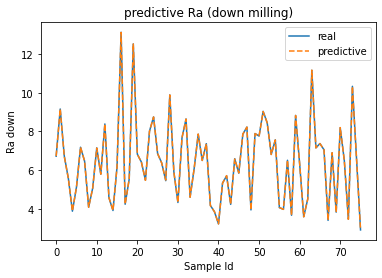

In [16]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

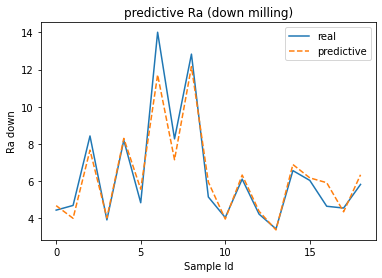

In [17]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

##### Using only vbs without Hyperparametertuning

In [18]:
X = all_data['vbs']
X = np.array(X)
X = X.reshape(-1, 1)
Y = all_data['Ra_{}'.format(up_or_down)]
Y = np.array(Y)
x_train, x_test , y_train, y_test= train_test_split(X, Y, test_size=0.2, random_state=20, shuffle=True)

In [19]:
lgbm = LGBMRegressor(random_state=20)
lgbm.fit(x_train, y_train)

LGBMRegressor(random_state=20)

In [20]:
y_fit = lgbm.predict(x_train)
y_pred = lgbm.predict(x_test)

**Test Metrics**

In [21]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 3.01
Coefficient of determination: 0.63
MAE:0.99
mean absolute percentage error:0.13


##### Using only vbs with Hyperparametertuning

In [22]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [23]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [24]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [25]:
lgbm_random.best_params_

{'num_leaves': 11, 'min_data_in_leaf': 2, 'max_depth': 5}

In [26]:
lgbm = LGBMRegressor(num_leaves=11, min_data_in_leaf=2, max_depth=5, random_state=20)
lgbm.fit(x_train, y_train)

LGBMRegressor(max_depth=5, min_data_in_leaf=2, num_leaves=11, random_state=20)

In [27]:
y_fit = lgbm.predict(x_train)
y_pred = lgbm.predict(x_test)

In [28]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 0.43
Coefficient of determination: 0.95
MAE:0.48
mean absolute percentage error:0.08


##### Using Vibrational Data only

In [29]:
up_or_down = 'down' # or down
all_data = pd.read_csv('../data/feature_set1/train_{}_Y.csv'.format(up_or_down))
all_data = all_data.drop(index = [48, 49, 51, 72, 91], axis = 0).reset_index(drop = True)  # remove outliers
all_data.head()

Nr.  spindle_speed   ap     fz   Ra_down   vbs   clamp_t1     clamp_t2  \
0    1           8000  0.2  0.050  12.83250   800  23.664093   917.580527   
1    2           8000  0.2  0.065   6.47625  1040  28.025455  1817.287671   
2    3           8000  0.2  0.075   8.42100  1200  24.258964  2600.600669   
3    4           8000  0.2  0.100   6.81600  1600  23.584906  4141.970983   
4    5           8000  0.4  0.050  12.51250   800  43.182927  1232.354156   

    clamp_t3  clamp_t4  ...  robot_t4  robot_t5  robot_t6  robot_t7  robot_t8  \
0  38.393060     131.0  ...    1159.0     340.0 -0.164626  3.279446  1.164723   
1  50.951992     153.0  ...    1114.0     286.0 -0.152276  2.869851  1.125636   
2  56.380290     175.0  ...    1205.0     350.0  0.195294  2.681590  1.214723   
3  68.429443     212.0  ...    1206.0     438.0 -0.022681  2.818957  1.221912   
4  55.606742     132.0  ...    1147.0     275.0  0.136498  2.464138  1.154345   

   robot_t9   clamp_f1   clamp_f2   robot_f1   robot_f2  
0  1.162811  12.222404  19.191919  22.863227  14.646465  
1  1.123908  17.382572  21.717172  25.495338  31.313131  
2  1.212308  20.770490  21.717172  37.602301  31.313131  
3  1.217963  27.491432  21.717172  39.944840   5.050505  
4  1.152213  18.159337   9.595960  33.502295   6.060606  

[5 rows x 28 columns]

In [30]:
used_feature = [#'spindle_speed', 'ap', 'fz','vbs', 
       'clamp_t1',
       'clamp_t2', 'clamp_t3', 'clamp_t4', 'clamp_t5', 'clamp_t6', 'clamp_t7', 'clamp_t8', 'clamp_t9',
       'clamp_f1', 'clamp_f2',
       'robot_t1', 'robot_t2', 'robot_t3', 'robot_t4', 'robot_t5', 'robot_t6', 'robot_t7', 'robot_t8', 'robot_t9',
       'robot_f1', 'robot_f2']

**Train-test-split**

In [31]:
X = all_data[used_feature]
Y = all_data['Ra_{}'.format(up_or_down)]

x_train, x_test , y_train, y_test= train_test_split(X, Y,test_size=0.2, random_state=20, shuffle=True)

In [32]:
x_train.columns

Index(['clamp_t1', 'clamp_t2', 'clamp_t3', 'clamp_t4', 'clamp_t5', 'clamp_t6',
       'clamp_t7', 'clamp_t8', 'clamp_t9', 'clamp_f1', 'clamp_f2', 'robot_t1',
       'robot_t2', 'robot_t3', 'robot_t4', 'robot_t5', 'robot_t6', 'robot_t7',
       'robot_t8', 'robot_t9', 'robot_f1', 'robot_f2'],
      dtype='object')

**Train the LGBM Regression Model**

In [33]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [34]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [35]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 5.58
Coefficient of determination: 0.31
MAE:1.78
mean_absolute_percentage_error:0.27


##### Using all Features with Hyperparametertuning

**Train the LGBM Regression Model**

In [36]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [37]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [ ]:
lgbm_random.fit(x_train, y_train)

In [39]:
lgbm_random.best_params_

{'num_leaves': 11, 'min_data_in_leaf': 3, 'max_depth': 95}

In [40]:
lgbm = LGBMRegressor(num_leaves=11, min_data_in_leaf=3, max_depth=95, random_state=20)

lgbm.fit(x_train, y_train,)

LGBMRegressor(max_depth=95, min_data_in_leaf=3, num_leaves=11, random_state=20)

In [41]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [42]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.14
Coefficient of determination: 0.97
MAE:0.08
mean_absolute_percentage_error:0.01


**Test Metrics**

In [43]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 4.90
Coefficient of determination: 0.40
MAE:1.64
mean_absolute_percentage_error:0.26


**Fit Result**

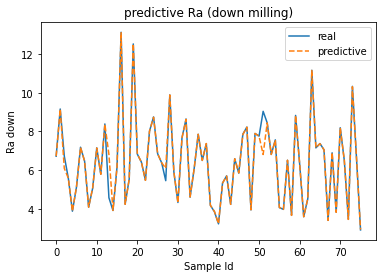

In [44]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

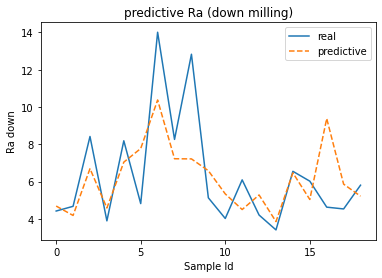

In [45]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Feature Set 2

##### Using all Features without Hyperparametertuning

In [311]:
train_data = pd.read_csv("../data/feature_set2/down_train_data.csv")
train_data = train_data.drop(columns=["Unnamed: 0"])
test_data = pd.read_csv("../data/feature_set2/down_test_data.csv")
test_data = test_data.drop(columns=["Unnamed: 0"])

**Train-test-split**

In [312]:
x_train = train_data.drop(columns=["Ra_down"])
x_test = test_data.drop(columns=["Ra_down"])
y_train = train_data["Ra_down"].values
y_test = test_data["Ra_down"].values

**Train the LGBM Regression Model**

In [48]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [49]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [50]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 3.43
Coefficient of determination: 0.58
MAE:1.11
mean_absolute_percentage_error:0.15


##### Using all Features with Hyperparametertuning

**Train the LGBM Regression Model**

In [51]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [52]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [53]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [54]:
lgbm_random.best_params_

{'num_leaves': 46, 'min_data_in_leaf': 4, 'max_depth': 230}

In [313]:
lgbm = LGBMRegressor(num_leaves=46, min_data_in_leaf=4, max_depth=230, random_state=20)

lgbm.fit(x_train, y_train,
        eval_metric='rmse')

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


LGBMRegressor(max_depth=230, min_data_in_leaf=4, num_leaves=46, random_state=20)

In [314]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [315]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.00
Coefficient of determination: 1.00
MAE:0.02
mean_absolute_percentage_error:0.00


**Test Metrics**

In [316]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 1.70
Coefficient of determination: 0.79
MAE:0.89
mean_absolute_percentage_error:0.13


**Fit Result**

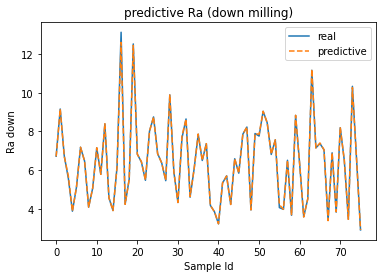

In [317]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

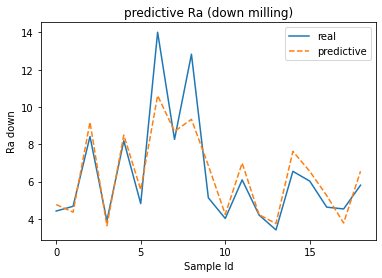

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is

In [318]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

##### Using Vibrational Data only

In [226]:
x_train = train_data.drop(columns=["Ra_down", "vbs", "ap", "fz", "spindle_speed"])
x_test = test_data.drop(columns=["Ra_down", "vbs", "ap", "fz", "spindle_speed"])
y_train = train_data["Ra_down"].values
y_test = test_data["Ra_down"].values

**Train the LGBM Regression Model**

In [62]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [63]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [64]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 6.06
Coefficient of determination: 0.25
MAE:1.85
mean_absolute_percentage_error:0.32


##### Using vibrational Data with Hyperparametertuning

**Train the LGBM Regression Model**

In [65]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [66]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [67]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [68]:
lgbm_random.best_params_

{'num_leaves': 11, 'min_data_in_leaf': 1, 'max_depth': 275}

In [227]:
lgbm = LGBMRegressor(num_leaves=11, min_data_in_leaf=1, max_depth=275, random_state=20)

lgbm.fit(x_train, y_train,
        eval_metric='rmse')

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


LGBMRegressor(max_depth=275, min_data_in_leaf=1, num_leaves=11, random_state=20)

In [228]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [229]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.14
Coefficient of determination: 0.97
MAE:0.08
mean_absolute_percentage_error:0.01


**Test Metrics**

In [230]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 7.14
Coefficient of determination: 0.12
MAE:1.85
mean_absolute_percentage_error:0.26


**Fit Result**

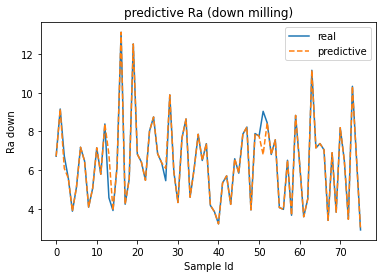

In [231]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

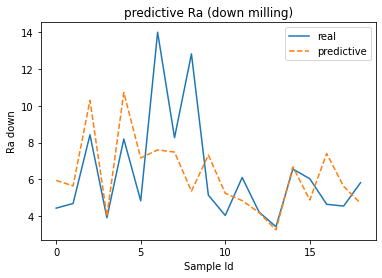

In [232]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Feature Set 3

In [233]:
train_data = pd.read_csv("../data/feature_set3/down_train_data.csv")
test_data = pd.read_csv("../data/feature_set3/down_test_data.csv")

##### Using all Features

In [234]:
x_train = train_data.drop(columns=["Unnamed: 0", "Ra_down"])
x_test = test_data.drop(columns=["Unnamed: 0", "Ra_down"])
y_train = train_data["Ra_down"]
y_test = test_data["Ra_down"]

In [235]:
mapper = {'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_2': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_2', 
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_77': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_77',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_3': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_3',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_36': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_36',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_72': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_72',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_90': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_90'}

In [236]:
x_train = x_train.rename(columns=mapper)  # rename cause LGBM does not support JSON formatted characters ("")
x_test = x_test.rename(columns=mapper)

**Train the LGBM Regression Model**

In [79]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [80]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [81]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 3.42
Coefficient of determination: 0.58
MAE:1.11
mean_absolute_percentage_error:0.15


##### Using all Features with Hyperparametertuning

**Train the LGBM Regression Model**

In [82]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [83]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [84]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [85]:
lgbm_random.best_params_

{'num_leaves': 11, 'min_data_in_leaf': 2, 'max_depth': 140}

In [237]:
lgbm = LGBMRegressor(num_leaves=11, min_data_in_leaf=2, max_depth=140, random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_metric='rmse')

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


LGBMRegressor(max_depth=140, min_data_in_leaf=2, num_leaves=11, random_state=20)

In [238]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [239]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.00
Coefficient of determination: 1.00
MAE:0.01
mean_absolute_percentage_error:0.00


**Test Metrics**

In [240]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 0.81
Coefficient of determination: 0.90
MAE:0.72
mean_absolute_percentage_error:0.11


**Fit Result**

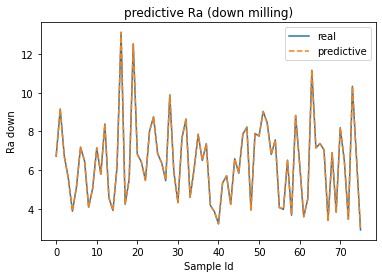

In [241]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

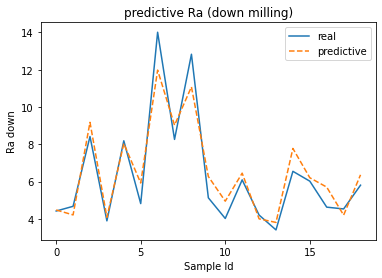

In [242]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

##### Using Vibrational Data only

In [243]:
x_train = train_data.drop(columns=["Unnamed: 0", "Ra_down", "spindle_speed", "vbs", "fz", "ap"])
x_test = test_data.drop(columns=["Unnamed: 0", "Ra_down", "spindle_speed", "vbs", "fz", "ap"])
y_train = train_data["Ra_down"]
y_test = test_data["Ra_down"]

In [244]:
mapper = {'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_2': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_2', 
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_77': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_77',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_3': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_3',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_36': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_36',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_72': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_72',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_90': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_90'}

In [245]:
x_train = x_train.rename(columns=mapper)  # rename cause LGBM does not support JSON formatted characters ("")
x_test = x_test.rename(columns=mapper)

**Train the LGBM Regression Model**

In [95]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [96]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [97]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 6.61
Coefficient of determination: 0.18
MAE:1.83
mean_absolute_percentage_error:0.28


##### Using vibrational Data with Hyperparametertuning

**Train the LGBM Regression Model**

In [98]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [99]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [100]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [101]:
lgbm_random.best_params_

{'num_leaves': 11, 'min_data_in_leaf': 3, 'max_depth': 95}

In [246]:
lgbm = LGBMRegressor(num_leaves=11, min_data_in_leaf=3, max_depth=95, random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_metric='rmse')

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


LGBMRegressor(max_depth=95, min_data_in_leaf=3, num_leaves=11, random_state=20)

In [247]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [248]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.14
Coefficient of determination: 0.97
MAE:0.08
mean_absolute_percentage_error:0.01


**Test Metrics**

In [249]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 5.18
Coefficient of determination: 0.36
MAE:1.69
mean_absolute_percentage_error:0.26


**Fit Result**

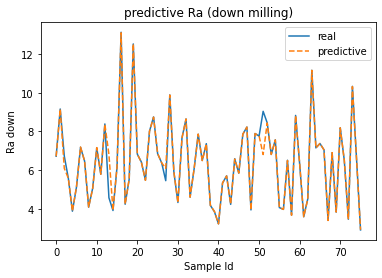

In [250]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

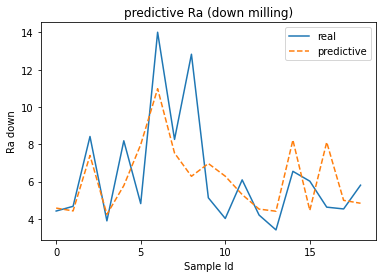

In [251]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

### Up Milling

#### Feature Set 1

##### Using all Features without Hyperparametertuning

In [319]:
up_or_down = 'up' # or down
all_data = pd.read_csv('../data/feature_set1/train_{}_Y.csv'.format(up_or_down))
all_data = all_data.drop(index = [48, 49, 51, 72, 91], axis=0).reset_index(drop=True)  # remove outliers
all_data.head()

Nr.  spindle_speed   ap     fz     Ra_up   vbs   clamp_t1     clamp_t2  \
0    1           8000  0.2  0.050  12.90500   800  26.229323  1295.769854   
1    2           8000  0.2  0.065   6.78175  1040  29.329545   994.685664   
2    3           8000  0.2  0.075   8.43450  1200  22.787313  1504.542610   
3    4           8000  0.2  0.100   6.77025  1600  28.397163  2118.802554   
4    5           8000  0.4  0.050  12.54250   800  43.666667   824.102151   

    clamp_t3  clamp_t4  ...  robot_t4  robot_t5  robot_t6  robot_t7  robot_t8  \
0  44.484558     155.0  ...    1210.0     384.0  0.295203  2.858728  1.223420   
1  43.024878     128.0  ...    1221.0     454.0  0.129026  2.502421  1.249903   
2  44.924273     151.0  ...    1246.0     474.0  0.202293  2.518253  1.249318   
3  54.015627     169.0  ...    1278.0     614.0  0.179430  2.414027  1.287632   
4  52.226146     126.0  ...    1128.0     311.0  0.169912  3.404943  1.141053   

   robot_t9   clamp_f1   clamp_f2   robot_f1  robot_f2  
0  1.219488  17.582900  21.717172  51.978762  5.050505  
1  1.244343  15.763967  21.717172  45.485476  4.545455  
2  1.243240  20.080109  21.717172  63.985078  5.050505  
3  1.278015  20.092329  21.717172  84.466924  5.050505  
4  1.139565  13.043699   9.595960  32.618295  6.060606  

[5 rows x 28 columns]

In [320]:
used_feature = ['spindle_speed', 'ap', 'fz','vbs', 'clamp_t1',
       'clamp_t2', 'clamp_t3', 'clamp_t4', 'clamp_t5', 'clamp_t6', 'clamp_t7', 'clamp_t8', 'clamp_t9',
       'clamp_f1', 'clamp_f2',
       'robot_t1', 'robot_t2', 'robot_t3', 'robot_t4', 'robot_t5', 'robot_t6', 'robot_t7', 'robot_t8', 'robot_t9',
       'robot_f1', 'robot_f2']

**Train-test-split**

In [254]:
X = all_data[used_feature]
Y = all_data['Ra_{}'.format(up_or_down)]

x_train, x_test , y_train, y_test= train_test_split(X, Y,test_size = 0.2, random_state=20, shuffle=True)

**Train the LGBM Regression Model**

In [111]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [112]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [113]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 3.04
Coefficient of determination: 0.63
MAE:1.16
mean_absolute_percentage_error:0.16


##### Using all Features with Hyperparametertuning

**Train the LGBM Regression Model**

In [114]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [115]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [116]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [117]:
lgbm_random.best_params_

{'num_leaves': 11, 'min_data_in_leaf': 4, 'max_depth': 50}

In [255]:
lgbm = LGBMRegressor(num_leaves=11, min_data_in_leaf=4, max_depth=50, random_state=20)

lgbm.fit(x_train, y_train,)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


LGBMRegressor(max_depth=50, min_data_in_leaf=4, num_leaves=11, random_state=20)

In [256]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [257]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.00
Coefficient of determination: 1.00
MAE:0.03
mean_absolute_percentage_error:0.00


**Test Metrics**

In [258]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 2.02
Coefficient of determination: 0.76
MAE:0.96
mean_absolute_percentage_error:0.14


**Fit Result**

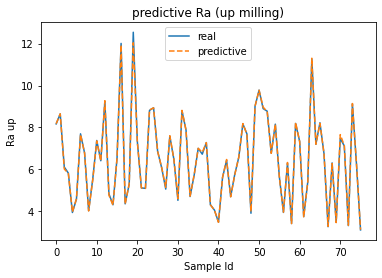

In [259]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

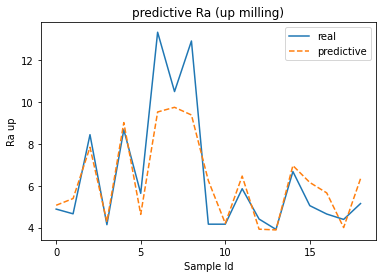

In [260]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

##### Using only vbs without Hyperparametertuning

In [261]:
X = all_data['vbs']
X = np.array(X)
X = X.reshape(-1, 1)
Y = all_data['Ra_{}'.format(up_or_down)]
Y = np.array(Y)
x_train, x_test , y_train, y_test= train_test_split(X, Y, test_size=0.2, random_state=20, shuffle=True)

In [262]:
lgbm = LGBMRegressor(random_state=20)
lgbm.fit(x_train, y_train)

LGBMRegressor(random_state=20)

In [126]:
y_fit = lgbm.predict(x_train)
y_pred = lgbm.predict(x_test)

**Test Metrics**

In [127]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 3.30
Coefficient of determination: 0.60
MAE:1.24
mean absolute percentage error:0.18


##### Using only vbs with Hyperparametertuning

In [128]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [129]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [130]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [131]:
lgbm_random.best_params_

{'num_leaves': 11, 'min_data_in_leaf': 2, 'max_depth': 5}

In [263]:
lgbm = LGBMRegressor(num_leaves=11, min_data_in_leaf=2, max_depth=5, random_state=20)
lgbm.fit(x_train, y_train)

LGBMRegressor(max_depth=5, min_data_in_leaf=2, num_leaves=11, random_state=20)

In [264]:
y_fit = lgbm.predict(x_train)
y_pred = lgbm.predict(x_test)

In [265]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 1.03
Coefficient of determination: 0.88
MAE:0.81
mean absolute percentage error:0.14


##### Using Vibrational Data only

In [321]:
up_or_down = 'up' # or down
all_data = pd.read_csv('../data/feature_set1/train_{}_Y.csv'.format(up_or_down))
all_data = all_data.drop(index = [48, 49, 51, 72, 91], axis = 0).reset_index(drop = True)  # remove outliers
all_data.head()

Nr.  spindle_speed   ap     fz     Ra_up   vbs   clamp_t1     clamp_t2  \
0    1           8000  0.2  0.050  12.90500   800  26.229323  1295.769854   
1    2           8000  0.2  0.065   6.78175  1040  29.329545   994.685664   
2    3           8000  0.2  0.075   8.43450  1200  22.787313  1504.542610   
3    4           8000  0.2  0.100   6.77025  1600  28.397163  2118.802554   
4    5           8000  0.4  0.050  12.54250   800  43.666667   824.102151   

    clamp_t3  clamp_t4  ...  robot_t4  robot_t5  robot_t6  robot_t7  robot_t8  \
0  44.484558     155.0  ...    1210.0     384.0  0.295203  2.858728  1.223420   
1  43.024878     128.0  ...    1221.0     454.0  0.129026  2.502421  1.249903   
2  44.924273     151.0  ...    1246.0     474.0  0.202293  2.518253  1.249318   
3  54.015627     169.0  ...    1278.0     614.0  0.179430  2.414027  1.287632   
4  52.226146     126.0  ...    1128.0     311.0  0.169912  3.404943  1.141053   

   robot_t9   clamp_f1   clamp_f2   robot_f1  robot_f2  
0  1.219488  17.582900  21.717172  51.978762  5.050505  
1  1.244343  15.763967  21.717172  45.485476  4.545455  
2  1.243240  20.080109  21.717172  63.985078  5.050505  
3  1.278015  20.092329  21.717172  84.466924  5.050505  
4  1.139565  13.043699   9.595960  32.618295  6.060606  

[5 rows x 28 columns]

In [322]:
used_feature = [#'spindle_speed', 'ap', 'fz','vbs', 
       'clamp_t1',
       'clamp_t2', 'clamp_t3', 'clamp_t4', 'clamp_t5', 'clamp_t6', 'clamp_t7', 'clamp_t8', 'clamp_t9',
       'clamp_f1', 'clamp_f2',
       'robot_t1', 'robot_t2', 'robot_t3', 'robot_t4', 'robot_t5', 'robot_t6', 'robot_t7', 'robot_t8', 'robot_t9',
       'robot_f1', 'robot_f2']

**Train-test-split**

In [323]:
X = all_data[used_feature]
Y = all_data['Ra_{}'.format(up_or_down)]

x_train, x_test , y_train, y_test= train_test_split(X, Y,test_size = 0.2, random_state=20, shuffle=True)

In [324]:
x_train.columns

Index(['clamp_t1', 'clamp_t2', 'clamp_t3', 'clamp_t4', 'clamp_t5', 'clamp_t6',
       'clamp_t7', 'clamp_t8', 'clamp_t9', 'clamp_f1', 'clamp_f2', 'robot_t1',
       'robot_t2', 'robot_t3', 'robot_t4', 'robot_t5', 'robot_t6', 'robot_t7',
       'robot_t8', 'robot_t9', 'robot_f1', 'robot_f2'],
      dtype='object')

**Train the LGBM Regression Model**

In [325]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [326]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [327]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 5.22
Coefficient of determination: 0.37
MAE:1.63
mean_absolute_percentage_error:0.24


##### Using vibrational Data only with Hyperparametertuning

**Train the LGBM Regression Model**

In [328]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [329]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [330]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [331]:
lgbm_random.best_params_

{'num_leaves': 51, 'min_data_in_leaf': 4, 'max_depth': 5}

In [332]:
lgbm = LGBMRegressor(num_leaves=51, min_data_in_leaf=4, max_depth=5, random_state=20)

lgbm.fit(x_train, y_train,)

LGBMRegressor(max_depth=5, min_data_in_leaf=4, num_leaves=51, random_state=20)

In [333]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [334]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.12
Coefficient of determination: 0.97
MAE:0.09
mean_absolute_percentage_error:0.02


**Test Metrics**

In [335]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 6.25
Coefficient of determination: 0.25
MAE:1.68
mean_absolute_percentage_error:0.23


**Fit Result**

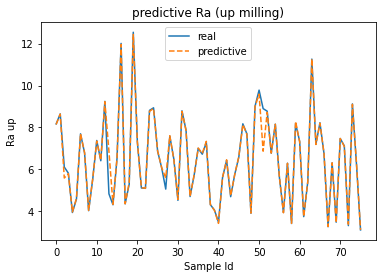

In [336]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

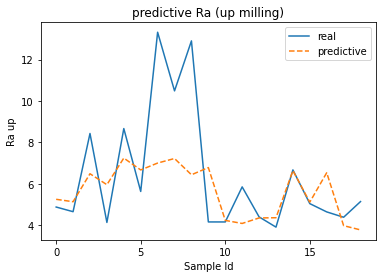

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

In [337]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Feature Set 2

##### Using all Features without Hyperparametertuning

In [275]:
train_data = pd.read_csv("../data/feature_set2/up_train_data.csv")
train_data = train_data.drop(columns=["Unnamed: 0"])
test_data = pd.read_csv("../data/feature_set2/up_test_data.csv")
test_data = test_data.drop(columns=["Unnamed: 0"])

**Train-test-split**

In [276]:
x_train = train_data.drop(columns=["Ra_up"])
x_test = test_data.drop(columns=["Ra_up"])
y_train = train_data["Ra_up"].values
y_test = test_data["Ra_up"].values

**Train the LGBM Regression Model**

In [154]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [155]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [156]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 2.77
Coefficient of determination: 0.67
MAE:1.17
mean_absolute_percentage_error:0.17


##### Using all Features with Hyperparametertuning

**Train the LGBM Regression Model**

In [157]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [158]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [159]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [160]:
lgbm_random.best_params_

{'num_leaves': 51, 'min_data_in_leaf': 4, 'max_depth': 5}

In [277]:
lgbm = LGBMRegressor(num_leaves=51, min_data_in_leaf=4, max_depth=5, random_state=20)

lgbm.fit(x_train, y_train,
        eval_metric='rmse')

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


LGBMRegressor(max_depth=5, min_data_in_leaf=4, num_leaves=51, random_state=20)

In [278]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [279]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.00
Coefficient of determination: 1.00
MAE:0.02
mean_absolute_percentage_error:0.00


**Test Metrics**

In [280]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 1.84
Coefficient of determination: 0.78
MAE:1.06
mean_absolute_percentage_error:0.17


**Fit Result**

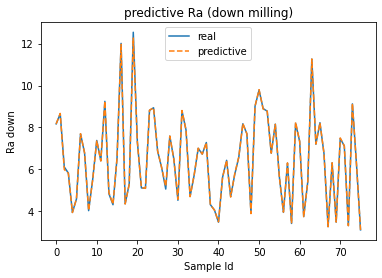

In [281]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

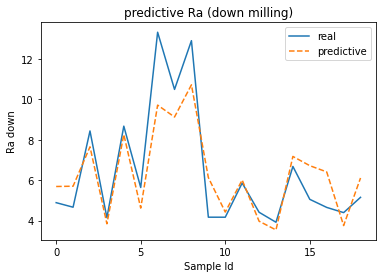

In [282]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

##### Using Vibrational Data only

In [283]:
x_train = train_data.drop(columns=["Ra_up", "vbs", "ap", "fz", "spindle_speed"])
x_test = test_data.drop(columns=["Ra_up", "vbs", "ap", "fz", "spindle_speed"])
y_train = train_data["Ra_up"].values
y_test = test_data["Ra_up"].values

**Train the LGBM Regression Model**

In [168]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [169]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [170]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 7.25
Coefficient of determination: 0.13
MAE:2.05
mean_absolute_percentage_error:0.31


##### Using vibrational Data with Hyperparametertuning

**Train the LGBM Regression Model**

In [171]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [172]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [173]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [174]:
lgbm_random.best_params_

{'num_leaves': 11, 'min_data_in_leaf': 4, 'max_depth': 50}

In [284]:
lgbm = LGBMRegressor(num_leaves=11, min_data_in_leaf=4, max_depth=50, random_state=20)

lgbm.fit(x_train, y_train,
        eval_metric='rmse')

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


LGBMRegressor(max_depth=50, min_data_in_leaf=4, num_leaves=11, random_state=20)

In [285]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [286]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.12
Coefficient of determination: 0.97
MAE:0.09
mean_absolute_percentage_error:0.01


**Test Metrics**

In [287]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 6.49
Coefficient of determination: 0.22
MAE:1.78
mean_absolute_percentage_error:0.27


**Fit Result**

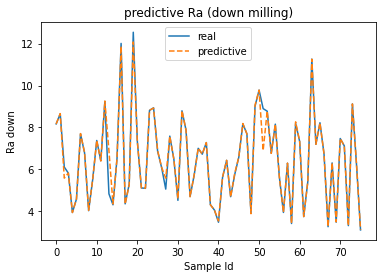

In [288]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

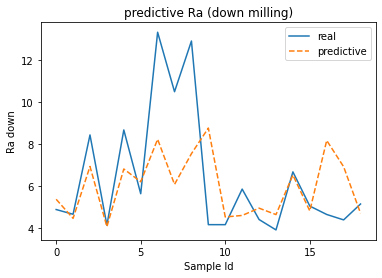

In [289]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Feature Set 3

In [290]:
train_data = pd.read_csv("../data/feature_set3/up_train_data.csv")
test_data = pd.read_csv("../data/feature_set3/up_test_data.csv")

##### Using all Features

In [291]:
x_train = train_data.drop(columns=["Unnamed: 0", "Ra_up"])
x_test = test_data.drop(columns=["Unnamed: 0", "Ra_up"])
y_train = train_data["Ra_up"]
y_test = test_data["Ra_up"]

In [292]:
mapper = {'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_3': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_3',
          'Clamp_Acceleration_Y__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"': 'Clamp_Acceleration_Y__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_max',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_True__qh_0_8__ql_0_0',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_False__qh_1.0__ql_0.0',
         'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.0',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_mean__isabs_True__qh_1.0__ql_0.0',
         'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_True__qh_0.8__ql_0.2',
         'Clamp_Acceleration_Y__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"': 'Clamp_Acceleration_Y__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_min',
         'Clamp_Acceleration_Y__fft_aggregated__aggtype_"kurtosis"': 'Clamp_Acceleration_Y__fft_aggregated__aggtype_kurtosis',
          'Clamp_Acceleration_Y__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"': 'Clamp_Acceleration_Y__agg_linear_trend__attr_intercept__chunk_len_10__f_agg_var',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_54': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_54',
          'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_41': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_41',
          'Clamp_Acceleration_Y__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"': 'Clamp_Acceleration_Y__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_var',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_True__qh_1.0__ql_0.0',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_mean__isabs_True__qh_0.8__ql_0.0',
         'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_True__qh_0.6__ql_0.0',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_74': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_74'}


In [293]:
x_train = x_train.rename(columns=mapper)  # rename cause LGBM does not support JSON formatted characters ("")
x_test = x_test.rename(columns=mapper)

**Train the LGBM Regression Model**

In [185]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [186]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [187]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 3.15
Coefficient of determination: 0.62
MAE:1.17
mean_absolute_percentage_error:0.17


##### Using all Features with Hyperparametertuning

**Train the LGBM Regression Model**

In [188]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [189]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [190]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [191]:
lgbm_random.best_params_

{'num_leaves': 46, 'min_data_in_leaf': 4, 'max_depth': 230}

In [294]:
lgbm = LGBMRegressor(num_leaves=46, min_data_in_leaf=4, max_depth=230, random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_metric='rmse')

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


LGBMRegressor(max_depth=230, min_data_in_leaf=4, num_leaves=46, random_state=20)

In [295]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [296]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.00
Coefficient of determination: 1.00
MAE:0.01
mean_absolute_percentage_error:0.00


**Test Metrics**

In [297]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 1.33
Coefficient of determination: 0.84
MAE:0.90
mean_absolute_percentage_error:0.16


**Fit Result**

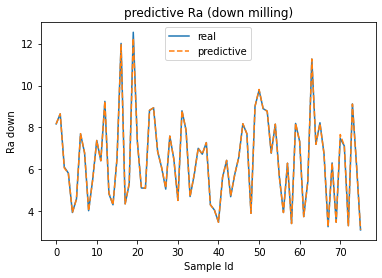

In [298]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

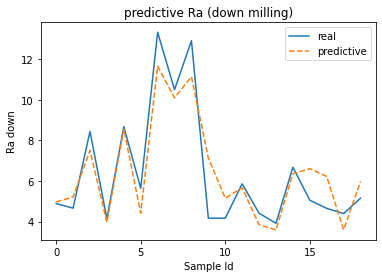

In [299]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

##### Using Vibrational Data only

##### Using all Features

In [300]:
x_train = train_data.drop(columns=["Unnamed: 0", "Ra_up", "spindle_speed", "vbs", "fz", "ap"])
x_test = test_data.drop(columns=["Unnamed: 0", "Ra_up", "spindle_speed", "vbs", "fz", "ap"])
y_train = train_data["Ra_up"]
y_test = test_data["Ra_up"]

In [301]:
mapper = {'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_3': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_3',
          'Clamp_Acceleration_Y__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"': 'Clamp_Acceleration_Y__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_max',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_True__qh_0_8__ql_0_0',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_False__qh_1.0__ql_0.0',
         'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_False__qh_0.8__ql_0.0',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_mean__isabs_True__qh_1.0__ql_0.0',
         'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_True__qh_0.8__ql_0.2',
         'Clamp_Acceleration_Y__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"': 'Clamp_Acceleration_Y__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_min',
         'Clamp_Acceleration_Y__fft_aggregated__aggtype_"kurtosis"': 'Clamp_Acceleration_Y__fft_aggregated__aggtype_kurtosis',
          'Clamp_Acceleration_Y__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"': 'Clamp_Acceleration_Y__agg_linear_trend__attr_intercept__chunk_len_10__f_agg_var',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_54': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_54',
          'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_41': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_41',
          'Clamp_Acceleration_Y__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"': 'Clamp_Acceleration_Y__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_var',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_True__qh_1.0__ql_0.0',
          'Clamp_Acceleration_Y__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_mean__isabs_True__qh_0.8__ql_0.0',
         'Clamp_Acceleration_Y__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0': 'Clamp_Acceleration_Y__change_quantiles__f_agg_var__isabs_True__qh_0.6__ql_0.0',
         'Clamp_Acceleration_Y__fft_coefficient__attr_"abs"__coeff_74': 'Clamp_Acceleration_Y__fft_coefficient__attr_abs__coeff_74'}


In [302]:
x_train = x_train.rename(columns=mapper)  # rename cause LGBM does not support JSON formatted characters ("")
x_test = x_test.rename(columns=mapper)

**Train the LGBM Regression Model**

In [201]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_set=[(x_test, y_test)],
        #eval_metric='rmse',)
        #early_stopping_rounds=30))

LGBMRegressor(random_state=20)

In [202]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Prediction Metrics**

In [203]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 5.73
Coefficient of determination: 0.31
MAE:1.72
mean_absolute_percentage_error:0.25


##### Using vibrational Data with Hyperparametertuning

**Train the LGBM Regression Model**

In [204]:
max_depth = np.linspace(5, 500, 12)
max_depth = np.append(max_depth, -1)
max_depth = max_depth.astype(int)
num_leaves = np.arange(11, 56, 5)
min_data_in_leaf = [1, 2, 3, 4]

param_distribution = {'max_depth': max_depth, 'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf}

In [205]:
lgbm = LGBMRegressor(random_state=20)
lgbm_random = RandomizedSearchCV(lgbm, param_distributions=param_distribution, n_iter=100, 
                               scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=20)

In [303]:
lgbm_random.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=20), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([  5,  50,  95, 140, 185, 230, 275, 320, 365, 410, 455, 500,  -1]),
                                        'min_data_in_leaf': [1, 2, 3, 4],
                                        'num_leaves': array([11, 16, 21, 26, 31, 36, 41, 46, 51])},
                   random_state=20, scoring='neg_mean_absolute_error')

In [304]:
lgbm_random.best_params_

{'num_leaves': 16, 'min_data_in_leaf': 2, 'max_depth': 5}

In [305]:
lgbm = LGBMRegressor(num_leaves=16, min_data_in_leaf=2, max_depth=5, random_state=20)

lgbm.fit(x_train, y_train,)
        #eval_metric='rmse')

LGBMRegressor(max_depth=5, min_data_in_leaf=2, num_leaves=16, random_state=20)

In [306]:
# predict test data
y_pred = lgbm.predict(x_test)

# fit train data
y_fit = lgbm.predict(x_train)

**Training Metrics**

In [307]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))

print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.12
Coefficient of determination: 0.97
MAE:0.07
mean_absolute_percentage_error:0.01


**Test Metrics**

In [308]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred,))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 5.50
Coefficient of determination: 0.34
MAE:1.74
mean_absolute_percentage_error:0.25


**Fit Result**

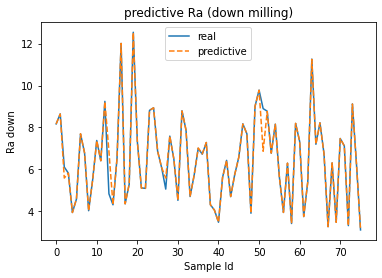

In [309]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_train)), y_train, label = "real")
plt.plot(range(len(y_fit)), y_fit, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**Prediction Result**

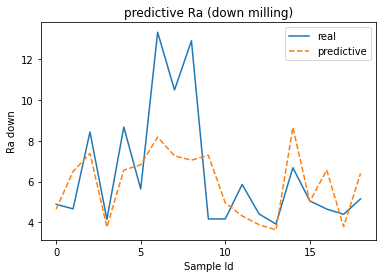

In [310]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(y_test)), y_test, label = "real")
plt.plot(range(len(y_pred)), y_pred, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Determine feature importance

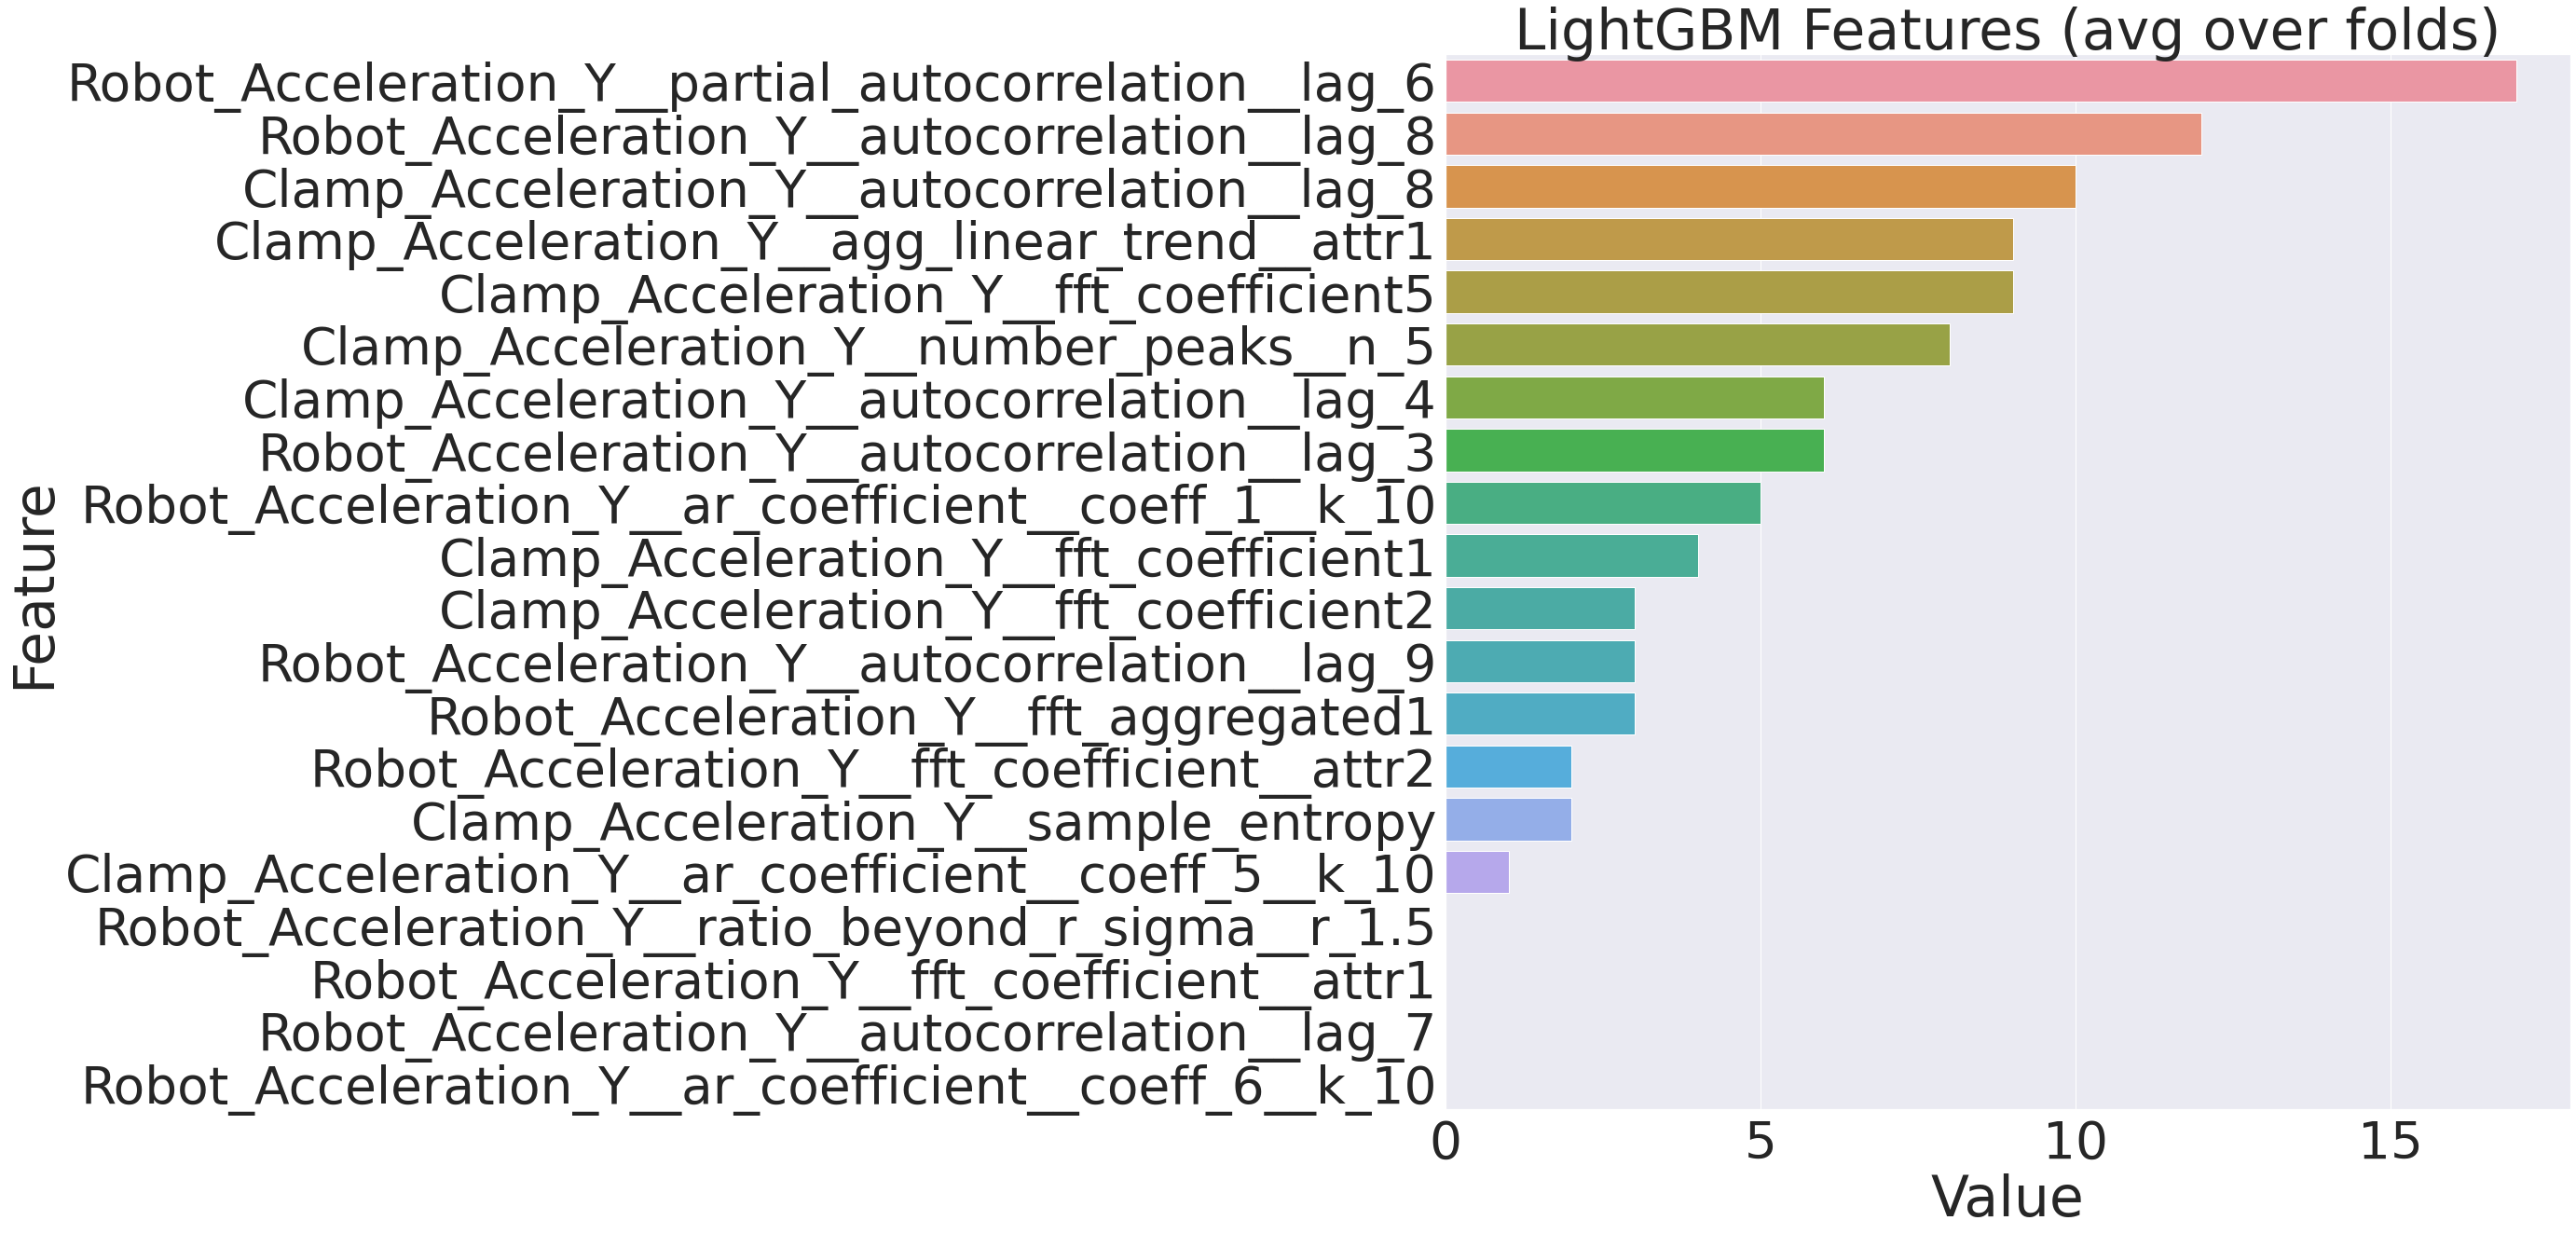

In [135]:
select_feature_num = 20
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize = fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data = feature_imp.sort_values(by = "Value", 
                                                        ascending = False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
#     plt.savefig('lgbm_importances-01.png')
    plt.show()
    return feature_imp

feature_imp = plotImp(lgbm, x_train, num = select_feature_num)

In [136]:
# top 20 important feature 
# 20
top20_feature_bytree = list(feature_imp.sort_values(by="Value", ascending=False)[:select_feature_num]['Feature'])

In [137]:
top20_feature_bytree

['Robot_Acceleration_Y__partial_autocorrelation__lag_6',
 'Robot_Acceleration_Y__autocorrelation__lag_8',
 'Clamp_Acceleration_Y__autocorrelation__lag_8',
 'Clamp_Acceleration_Y__agg_linear_trend__attr1',
 'Clamp_Acceleration_Y__fft_coefficient5',
 'Clamp_Acceleration_Y__number_peaks__n_5',
 'Clamp_Acceleration_Y__autocorrelation__lag_4',
 'Robot_Acceleration_Y__autocorrelation__lag_3',
 'Robot_Acceleration_Y__ar_coefficient__coeff_1__k_10',
 'Clamp_Acceleration_Y__fft_coefficient1',
 'Clamp_Acceleration_Y__fft_coefficient2',
 'Robot_Acceleration_Y__autocorrelation__lag_9',
 'Robot_Acceleration_Y__fft_aggregated1',
 'Robot_Acceleration_Y__fft_coefficient__attr2',
 'Clamp_Acceleration_Y__sample_entropy',
 'Clamp_Acceleration_Y__ar_coefficient__coeff_5__k_10',
 'Robot_Acceleration_Y__ratio_beyond_r_sigma__r_1.5',
 'Robot_Acceleration_Y__fft_coefficient__attr1',
 'Robot_Acceleration_Y__autocorrelation__lag_7',
 'Robot_Acceleration_Y__ar_coefficient__coeff_6__k_10']